In [1]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch as ch
import torchvision.transforms as transforms

# We also use the robustness library (https://robustness.readthedocs.io/en/latest/) for some 
# convenient functionality.
from robustness.tools.vis_tools import show_image_row
from robustness import model_utils, datasets

import helpers 

%matplotlib inline

## Load dataset 

For our interpretability experiments, we will use the ImageNet dataset from the ILSVRC challenge. This is a 1000 class dataset, that has played an important role in developing and evaluating deep learning models.

In [2]:
# Creater a loader for the dataset. In addition to the loader, we also need to obtain a
# normalization function. This is because standard deep networks are typically trained 
# on normalized images, so we need to apply the same normalization during testing. Finally,
# we also get a label map, that tells us what class a corresponding numeric value corresponds
# to.
in_loader, normalization_function, label_map_IN = helpers.load_dataset('imagenet',
                                                                 batch_size=5,
                                                                 num_workers=1)

==> Preparing dataset imagenet..


We can visualize some samples, along with their labels, from the dataset as follows

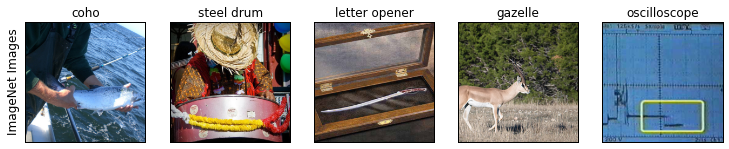

In [3]:
_, (img, targ) = next(enumerate(in_loader))

show_image_row([img],
              ["ImageNet Images"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ]])

## Load model

Next, we need a model to interpret! PyTorch provides access to a large range of pre-trained deep networks (for a full list, see <https://pytorch.org/docs/stable/torchvision/models.html>). For example, we can load a ResNet18 using the following code.

In [4]:
std_model = helpers.load_model('resnet18')

### Compute and visualize gradient

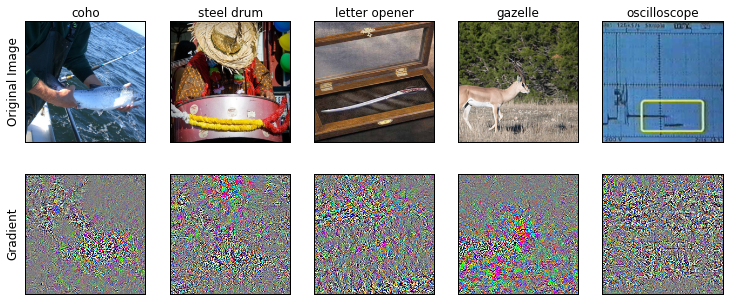

In [5]:
# We compute the gradient of the loss, with respect to the input. For every image pixel,
# the gradient tells us how the loss changes if we vary that pixel slightly.

grad, _ = helpers.get_gradient(std_model, img, targ, normalization_function)

# We can then visualize the original image, along with the gradient. Note that the gradient may
# not lie within the valid pixel range ([0, 1]), so we need to rescale it using the 
# `visualize_gradient` function.

show_image_row([img, helpers.visualize_gradient(grad)],
              ["Original Image", "Gradient"],
              tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### Implement SmoothGrad and visualize the results

In [6]:
def smooth_grad(mod, im, targ, normalization,
                Nsamples, stdev):
    # Instead of taking the gradient of a single image, we will take gradients
    # at a bunch of neighborhood points and average their gradients.
    
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)

    total_grad = 0
    for _, n in it:
        
        # Create a noisy version of the input image
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        # Compute gradient at noised version of the image
        grad, _ = helpers.get_gradient(mod, noised_im, targ, normalization)
        total_grad += grad
    
    # Return average gradient
    return total_grad / Nsamples

In [7]:
sgrad = smooth_grad(std_model, img, targ, normalization_function,
                    100, 0.3)

100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


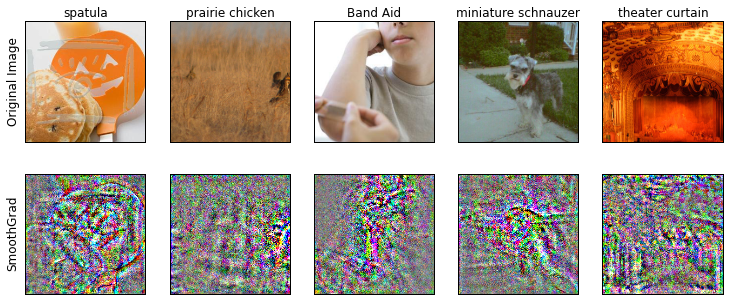

In [8]:
# We once again use the `visualize_gradient` helper to make the SmoothGrad suitable for 
# visualization.

show_image_row([img, helpers.visualize_gradient(sgrad)],
              ["Original Image", "SmoothGrad"],
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

## Adversarial examples

Since its discovery, the existance of adversarial examples has been one of the most extensively studied phenomena in deep learning. Essentially, it turns out that one can add an *imperceptible* perturbation to any input image and a standard (highly accurate) classifier will misclassify it. 

*Finding adversarial examples:* The idea is pretty simple: given a target class (t), we want to find a perturbation ($\delta'$) that when added to the input (x) maximizes the likelihood of the target class. At the same time, we want the perturbation to be small: for example lie in a tiny L2 ball around the image. Basically, we want to find a $\delta'$ such that

$\delta' = argmax_{||\delta||_2 \leq \epsilon} L(x + \delta, t; \theta)$


To find a perturbation that maximizes the objective (likelihood) while remaining in a bounded set, we use projected gradient descent PGD (see <https://arxiv.org/abs/1706.06083> for more). 

### Try it yourself! 

First choose a target class for every input. (Note that you have a batch of inputs, so you could try different targets for different inputs.)

In [13]:
TARGET = 3

print(f"Target class: {label_map_IN[TARGET]}")

target_class = 3 * ch.ones_like(targ)

Target class: tiger shark, Galeocerdo cuvieri


Next, there are a couple of parameters that you need to choose: 
1. eps: maximum size of the perturbation in terms of L2 norm. For e.g., eps=2 implies that $||\delta||_2 \leq 2$
2. Nsteps: number of (projected) gradient descent to perform
3. step_size: size of each step of (projected) gradient descent

In [14]:
# Create adversarial example
adv_ex = helpers.L2PGD(std_model, img, targ_class, normalization_function,
                       step_size=0.5, Nsteps=20, 
                       eps=1.25, targeted=True)

Loss: 0.06352519989013672: 100%|██████████| 20/20 [00:01<00:00, 18.76it/s] 


### Evaluate model predictions at perturbed inputs

In [15]:
with ch.no_grad():
    logits = helpers.forward_pass(std_model, 
                                      adv_ex, 
                                      normalization_function)
    pred_label = logits.argmax(dim=1)

### Visualize adversarial examples

In [ ]:
show_image_row([img, adv_ex], 
               tlist=[[label_map_IN[int(t)].split(',')[0] for t in label] \
                      for label in [targ, pred_label]])

## Robustness as a prior

### Load dataset and model (model is trained on a subset of ImageNet)

In [16]:
restricted_imagenet_ds, rin_loader, normalization_function = load_dataset('restricted_imagenet')
CD_rin = CLASS_DICT['RestrictedImageNet']

robust_model = load_model('robust', restricted_imagenet_ds)

==> Preparing dataset restricted_imagenet..
=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


### Visualize gradient

In [17]:
_, (img, targ) = next(enumerate(rin_loader))

In [18]:
grad_rob, _ = get_gradient(robust_model, img, targ)

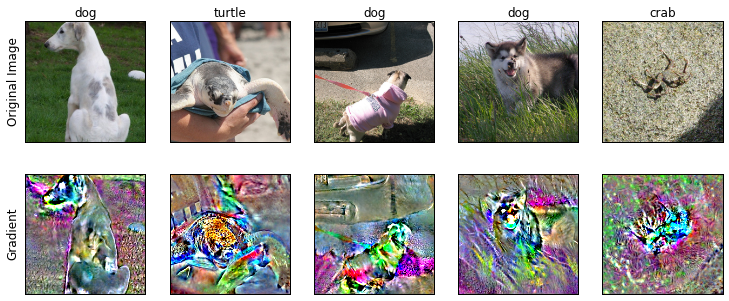

In [19]:
show_image_row([img, vis_tensor(grad_rob)],
              ["Original Image", "Gradient"],
              tlist=[[CD_rin[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### Adversarial Example

In [20]:
targ_class = 1 * ch.ones_like(targ)
adv_ex = create_l2_adv_examples(robust_model, img, targ_class, 0.5, 20, 
                                targeted=True, eps=1.25)
with ch.no_grad():
    pred_label = forward_pass(robust_model, adv_ex).argmax(dim=1)

Loss: 4.793150901794434: 100%|██████████| 20/20 [00:01<00:00, 11.81it/s] 


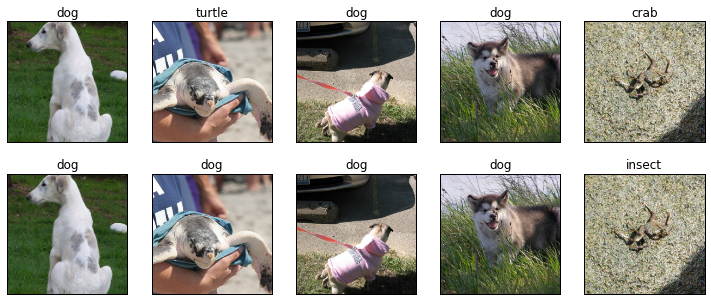

In [21]:
show_image_row([img, adv_ex], 
               tlist=[[CD_rin[int(t)].split(',')[0] for t in label] for label in [targ, pred_label]])

### Gradients induce semantically meaningful changes in input

In [22]:
targ_class = 5 * ch.ones_like(targ)
im_targ = create_l2_adv_examples(robust_model, img, targ_class, 5, 20, 
                                custom_loss=None, normalize=True)

Loss: 0.0: 100%|██████████| 20/20 [00:01<00:00, 15.42it/s]                   


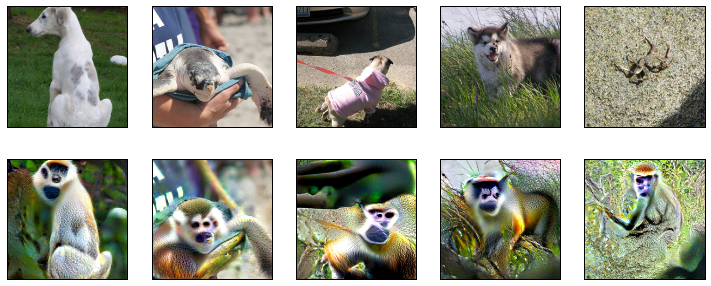

In [23]:
show_image_row([img, im_targ])

### Feature Visualization

In [24]:
def get_feature_representation(mod, im):
    feature_rep = ch.nn.Sequential(*list(mod.children())[:-1])
    im_norm = normalization_function(im.cpu()).cuda()
    return feature_rep(im_norm)[:, :, 0, 0]

def feature_maximization_loss(mod, im, targ):
    fr = get_feature_representation(mod, im)
    loss = ch.mean(ch.gather(fr, 1, targ[:, None]))
    return loss

In [25]:
targ_class = 700 * ch.ones_like(targ)
im_f = create_l2_adv_examples(robust_model, img, targ_class, 5, 20, 
                                custom_loss=feature_maximization_loss, 
                                targeted=False, normalize=True)

Loss: 1.9394140243530273: 100%|██████████| 20/20 [00:01<00:00, 14.85it/s]


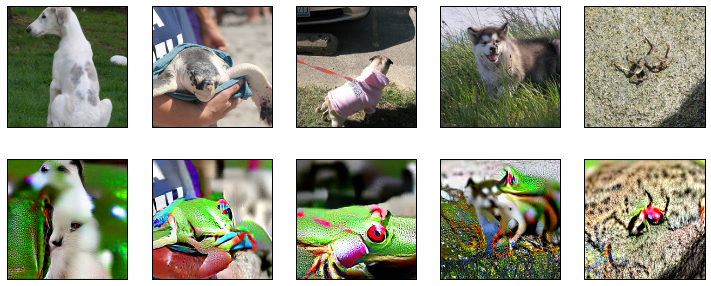

In [26]:
show_image_row([img, im_f])

#### From noise

In [27]:
noise_img = ch.clamp(ch.randn_like(img) + 0.5, 0, 1)

targ_class = 231 * ch.ones_like(targ)
im_f = create_l2_adv_examples(robust_model, noise_img, targ_class, 5, 200, 
                                custom_loss=feature_maximization_loss, 
                                targeted=False, normalize=True)

Loss: 4.81898832321167: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]   


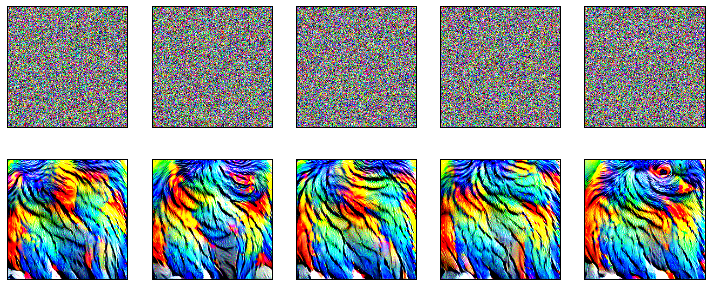

In [28]:
show_image_row([noise_img, im_f])

#### Try the same for a standard model

In [29]:
_, (img, targ) = next(enumerate(in_loader))

targ_class = 100 * ch.ones_like(targ)
im_f = create_l2_adv_examples(std_model, img, targ_class, 5, 20, 
                                custom_loss=feature_maximization_loss, 
                                targeted=False, normalize=True)

Loss: 43.41929626464844: 100%|██████████| 20/20 [00:00<00:00, 37.03it/s] 


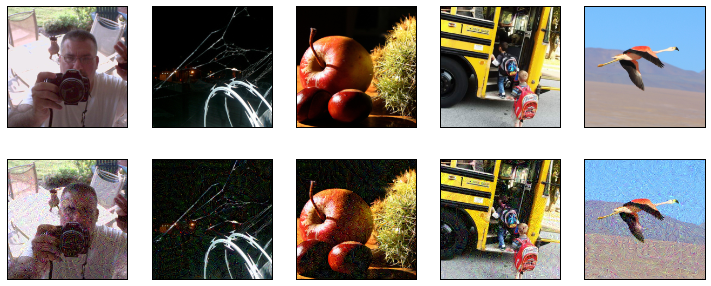

In [30]:
show_image_row([img, im_f])